# Изучение синтетической банковской выписки

## План работ
1. **Построение модели классификации** для определения степени риска транзакции.  
   Цель — получить на выходе не только класс риска, но и числовой коэффициент уверенности модели.
2. **Оценка качества классификации**: точность (accuracy) по каждому классу должна быть выше 25%,  
   что превышает вероятность случайного выбора (1 из 4 классов).
3. **Интеграция с LLM**: сформировать промпт, который учитывает как текстовое описание транзакции,  
   так и результат классификации (коэффициент риска).
4. **Генерация объяснений LLM**: получить развернутые и понятные пользователю пояснения,  
   почему операция отнесена к конкретной категории риска.
5. **Анализ эффективности LLM**: при низкой точности или неинформативных ответах — адаптировать промпт  
   и повторить оценку.

## Цели исследования
- Проверить, можно ли эффективно классифицировать степень риска банковских операций  
  с помощью моделей машинного обучения (классификации и кластеризации).
- Проверить, помогут ли результаты ML-модели улучшить способность LLM  
  давать корректные и объяснимые интерпретации риска.

### Почему использовать что-то кроме LLM?
LLM-модели способны давать качественные объяснения, но требуют значительных вычислительных ресурсов.  
Модель машинного обучения (например, логистическая регрессия или XGBoost) может служить **фильтром**:  
она предварительно отсеивает операции с низким риском, оставляя LLM только потенциально подозрительные транзакции.  
Это позволяет **снизить нагрузку на LLM** и повысить общую эффективность системы.


## Анализ исходных данных

### Задача
На основе синтетической банковской выписки необходимо:

1. **Провести исследовательский анализ данных (EDA)** — определить, какие признаки (например, суммы, контрагенты, назначение платежа) могут влиять на степень риска транзакции.
2. **Визуализировать зависимости** между различными характеристиками и классами риска, чтобы выявить возможные закономерности.
3. **Создать дополнительные признаки (feature engineering)**, если обнаружатся сильные зависимости.  
   Например:
   - наличие слова “займ” в назначении платежа может быть индикатором высокого риска → создать бинарный признак `has_loan_word = 1`;
   - крупные суммы перевода могут быть связаны с повышенным риском → добавить `is_large_amount = 1` при сумме > X.
4. **Подготовить набор данных для обучения модели классификации** — нормализовать числовые признаки, закодировать категориальные поля, удалить избыточные колонки.

### Цель этапа
Создать качественно подготовленный датасет, в котором каждая транзакция представлена набором информативных признаков, влияющих на риск, и может быть использована для обучения ML-модели.


In [1]:
# Импортируем необходимые библиотеки для анализа и виузализации данных
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
# Отобразим первые 5 строк нашего датасета
df = pd.read_csv('data/statement_main.csv')
df.head()

,date,debit_account,debit_name,debit_inn,credit_account,credit_name,credit_inn,debit_amount,credit_amount,purpose,risk,risk_comment
0,2025-08-01 00:03:25,40702810900000123456,"ООО ""СтройГарант""",7712345678,79237474074821759464,"ООО ""Фирма_1023""",7436713695,752086.74,NaN,Возврат денежных средств по счёту №92047 от 25...,Низкий,Возврат по счёту/корректировка
1,2025-08-01 00:10:17,40702810900000123456,"ООО ""СтройГарант""",7712345678,74016400524278680112,Кузнецов И.И.,980500978820,1383526.15,NaN,Оплата по договору поставки №3679 от 01.08.202...,Низкий,Регулярная обязательная выплата
2,2025-08-01 00:11:37,40702810900000123456,"ООО ""СтройГарант""",7712345678,90916998543534624751,Иванов П.П.,624731781080,1396035.42,NaN,Оплата по договору поставки №1370 от 01.08.202...,Низкий,Регулярная обязательная выплата
3,2025-08-01 00:12:06,40702810900000123456,"ООО ""СтройГарант""",7712345678,72774348734714345581,"ООО ""Фирма_1005""",2236231665,306956.29,NaN,Оплата услуг по договору №US-8402 от 01.08.202...,Низкий,Оплата услуг по договору
4,2025-08-01 00:14:01,40702810900000123456,"ООО ""СтройГарант""",7712345678,23226025634216073375,"ООО ""Фирма_1000""",4330365414,386349.95,NaN,"Разовый перевод, основание: компенсация затрат...",Средний,Операция стандартного типа — рекомендована све...


In [3]:
print("Размер:", df.shape)
display(df.head(3))
print("\nИнформация о типах данных:")
df.info()
print("\nПропуски в данных:")
print(df.isna().sum())
print("\nЧисловая статистика:")
display(df.describe())

Размер: (20000, 12)


,date,debit_account,debit_name,debit_inn,credit_account,credit_name,credit_inn,debit_amount,credit_amount,purpose,risk,risk_comment
0,2025-08-01 00:03:25,40702810900000123456,"ООО ""СтройГарант""",7712345678,79237474074821759464,"ООО ""Фирма_1023""",7436713695,752086.74,NaN,Возврат денежных средств по счёту №92047 от 25...,Низкий,Возврат по счёту/корректировка
1,2025-08-01 00:10:17,40702810900000123456,"ООО ""СтройГарант""",7712345678,74016400524278680112,Кузнецов И.И.,980500978820,1383526.15,NaN,Оплата по договору поставки №3679 от 01.08.202...,Низкий,Регулярная обязательная выплата
2,2025-08-01 00:11:37,40702810900000123456,"ООО ""СтройГарант""",7712345678,90916998543534624751,Иванов П.П.,624731781080,1396035.42,NaN,Оплата по договору поставки №1370 от 01.08.202...,Низкий,Регулярная обязательная выплата



Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            20000 non-null  object 
 1   debit_account   20000 non-null  object 
 2   debit_name      20000 non-null  object 
 3   debit_inn       20000 non-null  int64  
 4   credit_account  20000 non-null  object 
 5   credit_name     20000 non-null  object 
 6   credit_inn      20000 non-null  int64  
 7   debit_amount    13191 non-null  float64
 8   credit_amount   6809 non-null   float64
 9   purpose         20000 non-null  object 
 10  risk            20000 non-null  object 
 11  risk_comment    20000 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 1.8+ MB

Пропуски в данных:
date                  0
debit_account         0
debit_name            0
debit_inn             0
credit_account        0
credit_name           0
credit_

,debit_inn,credit_inn,debit_amount,credit_amount
count,2.000000e+04,2.000000e+04,1.319100e+04,6.809000e+03
mean,2.937777e+10,5.114521e+10,6.237229e+05,1.045610e+06
std,1.286493e+11,1.783995e+11,5.699700e+05,8.538455e+05
min,4.711383e+07,4.711383e+07,5.855200e+02,5.892100e+02
25%,7.712346e+09,5.865781e+09,2.095048e+05,3.731792e+05
50%,7.712346e+09,7.712346e+09,5.404174e+05,8.095935e+05
75%,7.712346e+09,7.712346e+09,8.782475e+05,1.586269e+06
max,9.805010e+11,9.805010e+11,4.998691e+06,4.990026e+06


In [4]:
import pandas as pd
from collections import Counter

# Убираем кавычки и переводим всё в нижний регистр
clean_text = (
    df["purpose"]
    .astype(str)
    .str.replace(r'[\"\'«»“”]', '', regex=True)  # убираем кавычки
    .str.lower()
)

# Разбиваем на слова и "разворачиваем" их в один столбец
words = clean_text.str.split().explode()

# Подсчитываем частоту слов
word_counts = words.value_counts().reset_index()
word_counts.columns = ["word", "count"]

# Смотрим результат
print(word_counts.head(50))


               word  count
0                по  22578
1            оплата  13773
2                от  13016
3          договору   8576
4           разовый   6568
5        основание:   6568
6             счёту   4956
7          перевод,   4249
8               акт   3585
9             услуг   3585
10         поставки   2526
11               за   2396
12          приход:   2319
13             счет   2123
14              ндс   2060
15          возврат   1998
16           аванса   1391
17  (предоставление   1331
18          услуг),   1331
19           ошибке   1312
20    бухгалтерской   1312
21    корректировка   1312
22    задолженности   1301
23   договоренности   1301
24           устной   1301
25        погашение   1301
26      компенсация   1299
27           затрат   1299
28             акту   1299
29              без   1270
30        накладной   1265
31       проведение   1265
32         расчетов   1265
33     счет-фактура   1256
34       (покупка),   1256
35               на   1230
3

In [5]:
import pandas as pd
import re

# Укажи нужную колонку
col = "debit_name"  # можно заменить на credit_account

# Приводим колонку к строковому виду и убираем NaN
accounts = df[col].astype(str).fillna("")

# Полный список распространённых юридических обозначений (можно дополнять)
legal_forms = [
    "ООО", "ИП", "АО", "ПАО", "ЗАО", "ОАО",
    "ГУП", "МУП", "ФГУП", "НКО", "АНО", "ТОО", "ОДО", "ЧУП", "КФХ",
    "ПК", "ПТ", "СПК", "СНТ", "ТСЖ", "ЖСК", "ОП", "НП", "ФП", "Ассоциация", "Союз"
]

# Подготовим регулярные выражения для каждого типа
patterns = {form: re.compile(rf'\b{form}\b', re.IGNORECASE) for form in legal_forms}

def detect_legal_form(text):
    """Определяем юридическую форму организации по тексту"""
    cleaned = re.sub(r'[\"«»“”,.()*/]', ' ', text)  # убираем кавычки и знаки
    tokens = re.split(r'\s+', cleaned.strip())      # разбиваем по пробелам
    tokens_upper = [t.upper() for t in tokens if t] # приводим к верхнему регистру
    
    for form, pattern in patterns.items():
        if any(pattern.search(t) for t in tokens_upper):
            return form
    return "Другое"

# Применяем к колонке
df[f"{col}_type"] = accounts.apply(detect_legal_form)

# Считаем количество уникальных организаций по типам
org_counts = (
    df.groupby(f"{col}_type")[col]
    .nunique()
    .reset_index()
    .rename(columns={col: "Количество уникальных наименований"})
    .sort_values("Количество уникальных наименований", ascending=False)
)

# Выводим результаты
print("=== Примеры найденных юридических форм ===")
for form in df[f"{col}_type"].unique():
    examples = df.loc[df[f"{col}_type"] == form, col].unique()[:5]
    print(f"\n{form}:")
    for e in examples:
        print("  •", e)

print("\n=== Статистика по типам организаций ===")
display(org_counts)



=== Примеры найденных юридических форм ===

ООО:
  • ООО "СтройГарант"
  • ООО "Фирма_1005"
  • ООО "Фирма_1017"
  • ООО "РемСервис"
  • ООО "Фирма_1008"

Другое:
  • Иванов П.П.
  • Петров А.А.
  • Кузнецов И.И.
  • Смирнова А.А.
  • Сидоров В.В.

АО:
  • АО "Банк Финанс"

ПАО:
  • ПАО "НацБанк"

=== Статистика по типам организаций ===


,debit_name_type,Количество уникальных наименований
2,ООО,41
1,Другое,5
0,АО,1
3,ПАО,1


In [6]:
import pandas as pd
import re

# Укажи нужную колонку
col = "credit_name"  # можно заменить на credit_account

# Приводим колонку к строковому виду и убираем NaN
accounts = df[col].astype(str).fillna("")

# Полный список распространённых юридических обозначений (можно дополнять)
legal_forms = [
    "ООО", "ИП", "АО", "ПАО", "ЗАО", "ОАО",
    "ГУП", "МУП", "ФГУП", "НКО", "АНО", "ТОО", "ОДО", "ЧУП", "КФХ",
    "ПК", "ПТ", "СПК", "СНТ", "ТСЖ", "ЖСК", "ОП", "НП", "ФП", "Ассоциация", "Союз"
]

# Подготовим регулярные выражения для каждого типа
patterns = {form: re.compile(rf'\b{form}\b', re.IGNORECASE) for form in legal_forms}

def detect_legal_form(text):
    """Определяем юридическую форму организации по тексту"""
    cleaned = re.sub(r'[\"«»“”,.()*/]', ' ', text)  # убираем кавычки и знаки
    tokens = re.split(r'\s+', cleaned.strip())      # разбиваем по пробелам
    tokens_upper = [t.upper() for t in tokens if t] # приводим к верхнему регистру
    
    for form, pattern in patterns.items():
        if any(pattern.search(t) for t in tokens_upper):
            return form
    return "Другое"

# Применяем к колонке
df[f"{col}_type"] = accounts.apply(detect_legal_form)

# Считаем количество уникальных организаций по типам
org_counts = (
    df.groupby(f"{col}_type")[col]
    .nunique()
    .reset_index()
    .rename(columns={col: "Количество уникальных наименований"})
    .sort_values("Количество уникальных наименований", ascending=False)
)

# Выводим результаты
print("=== Примеры найденных юридических форм ===")
for form in df[f"{col}_type"].unique():
    examples = df.loc[df[f"{col}_type"] == form, col].unique()[:5]
    print(f"\n{form}:")
    for e in examples:
        print("  •", e)

print("\n=== Статистика по типам организаций ===")
display(org_counts)


=== Примеры найденных юридических форм ===

ООО:
  • ООО "Фирма_1023"
  • ООО "Фирма_1005"
  • ООО "Фирма_1000"
  • ООО "СтройГарант"
  • ООО "Фирма_1019"

Другое:
  • Кузнецов И.И.
  • Иванов П.П.
  • Смирнова А.А.
  • Сидоров В.В.
  • Петров А.А.

ПАО:
  • ПАО "НацБанк"

АО:
  • АО "Банк Финанс"

=== Статистика по типам организаций ===


,credit_name_type,Количество уникальных наименований
2,ООО,41
1,Другое,5
0,АО,1
3,ПАО,1


In [7]:
df.head()

,date,debit_account,debit_name,debit_inn,credit_account,credit_name,credit_inn,debit_amount,credit_amount,purpose,risk,risk_comment,debit_name_type,credit_name_type
0,2025-08-01 00:03:25,40702810900000123456,"ООО ""СтройГарант""",7712345678,79237474074821759464,"ООО ""Фирма_1023""",7436713695,752086.74,NaN,Возврат денежных средств по счёту №92047 от 25...,Низкий,Возврат по счёту/корректировка,ООО,ООО
1,2025-08-01 00:10:17,40702810900000123456,"ООО ""СтройГарант""",7712345678,74016400524278680112,Кузнецов И.И.,980500978820,1383526.15,NaN,Оплата по договору поставки №3679 от 01.08.202...,Низкий,Регулярная обязательная выплата,ООО,Другое
2,2025-08-01 00:11:37,40702810900000123456,"ООО ""СтройГарант""",7712345678,90916998543534624751,Иванов П.П.,624731781080,1396035.42,NaN,Оплата по договору поставки №1370 от 01.08.202...,Низкий,Регулярная обязательная выплата,ООО,Другое
3,2025-08-01 00:12:06,40702810900000123456,"ООО ""СтройГарант""",7712345678,72774348734714345581,"ООО ""Фирма_1005""",2236231665,306956.29,NaN,Оплата услуг по договору №US-8402 от 01.08.202...,Низкий,Оплата услуг по договору,ООО,ООО
4,2025-08-01 00:14:01,40702810900000123456,"ООО ""СтройГарант""",7712345678,23226025634216073375,"ООО ""Фирма_1000""",4330365414,386349.95,NaN,"Разовый перевод, основание: компенсация затрат...",Средний,Операция стандартного типа — рекомендована све...,ООО,ООО


In [8]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# ======== 1. Бинарные признаки по ключевым словам в purpose ========
df["purpose"] = df["purpose"].astype(str).fillna("")

risk_keywords = {
    # Высокий риск
    "loan_related": ["займ", "договор займа", "возврат займа"],
    "unclear_transfer": ["взаиморасчёт", "перевод средств", "без договора", "перевод на карту"],
    "no_contract": ["оплата без договора", "прочие расходы", "личные нужды"],
    "crypto_activity": ["крипто", "биткоин", "usdt", "биржа", "coin", "crypto"],
    "foreign_payment": ["иностранный перевод", "swift", "валютный счёт", "экспорт"],
    "related_party_transfer": ["возврат займа", "займ физ. лицу", "передача активов"],
    "cash_out": ["пополнение", "наличные", "выдача наличных", "обналичивание"],
    "donation": ["благотворительность", "пожертвование"],
    "agent_fee": ["агентское вознаграждение", "комиссионное"],

    # Средний риск
    "service_payment": ["оплата услуг", "услуги по договору", "консультационные", "маркетинг"],
    "bonus_related": ["премия", "бонус", "вознаграждение"],
    "advance_payment": ["аванс", "предоплата", "частичная оплата"],
    "lease_payment": ["аренда", "лизинг", "субаренда"],
    "logistics": ["логистика", "транспорт", "перевозка"],

    # Низкий/без риска
    "has_docs": ["оплата по договору", "счёт-фактура", "акт выполненных работ", "ттн"],
    "salary_related": ["зарплата", "заработная плата", "компенсация отпуска", "взносы"],
    "utilities": ["коммунальные услуги", "аренда офиса", "интернет", "телефон"],
    "tax_payment": ["налоги", "страховые взносы", "пфр", "фнс", "пенсионный фонд"],
    "supplier_payment": ["поставщик", "поставка", "товары", "материалы", "сырьё"],
    "internal_transfer": ["внутренний перевод", "между счетами организации"]
}

# Создание бинарных колонок
for col_name, keywords in risk_keywords.items():
    pattern = r'(' + '|'.join([re.escape(k.lower()) for k in keywords]) + r')'
    df[col_name] = df["purpose"].str.lower().str.contains(pattern, regex=True).astype(int)

# ======== 2. Label Encoding для risk ========
le_risk = LabelEncoder()
df['risk_encoded'] = le_risk.fit_transform(df['risk'].astype(str))

# Проверка соответствия
print("Соответствие классов risk:")
for cls, code in zip(le_risk.classes_, range(len(le_risk.classes_))):
    print(f"{cls} -> {code}")

# ======== 3. OneHotEncoding для debit_name_type и credit_name_type ========
ohe = OneHotEncoder(sparse_output=False, dtype=int)

cat_cols = ["debit_name_type", "credit_name_type"]
encoded = ohe.fit_transform(df[cat_cols])

encoded_cols = ohe.get_feature_names_out(cat_cols)
df_encoded = pd.DataFrame(encoded, columns=encoded_cols, index=df.index)

# Объединяем с исходным DataFrame
df_final = pd.concat([df, df_encoded], axis=1)

# ======== 4. Проверка ========
print(df_final.head())



/var/folders/hx/6vltr8z949358k44l1m6_b7m0000gn/T/ipykernel_1418/2527486234.py:39: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[col_name] = df["purpose"].str.lower().str.contains(pattern, regex=True).astype(int)
/var/folders/hx/6vltr8z949358k44l1m6_b7m0000gn/T/ipykernel_1418/2527486234.py:39: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[col_name] = df["purpose"].str.lower().str.contains(pattern, regex=True).astype(int)
/var/folders/hx/6vltr8z949358k44l1m6_b7m0000gn/T/ipykernel_1418/2527486234.py:39: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[col_name] = df["purpose"].str.lower().str.contains(pattern, regex=True).astype(int)
/var/folders/hx/6vltr8z949358k44l1m6_b7m0000gn/T/ipykernel_1418/2527486234.py:39: UserWa

Соответствие классов risk:
Высокий -> 0
Низкий -> 1
Средний -> 2
                  date         debit_account         debit_name   debit_inn  \
0  2025-08-01 00:03:25  40702810900000123456  ООО "СтройГарант"  7712345678   
1  2025-08-01 00:10:17  40702810900000123456  ООО "СтройГарант"  7712345678   
2  2025-08-01 00:11:37  40702810900000123456  ООО "СтройГарант"  7712345678   
3  2025-08-01 00:12:06  40702810900000123456  ООО "СтройГарант"  7712345678   
4  2025-08-01 00:14:01  40702810900000123456  ООО "СтройГарант"  7712345678   

         credit_account       credit_name    credit_inn  debit_amount  \
0  79237474074821759464  ООО "Фирма_1023"    7436713695     752086.74   
1  74016400524278680112     Кузнецов И.И.  980500978820    1383526.15   
2  90916998543534624751       Иванов П.П.  624731781080    1396035.42   
3  72774348734714345581  ООО "Фирма_1005"    2236231665     306956.29   
4  23226025634216073375  ООО "Фирма_1000"    4330365414     386349.95   

   credit_amount     

In [9]:
df_final.columns

Index(['date', 'debit_account', 'debit_name', 'debit_inn', 'credit_account',
       'credit_name', 'credit_inn', 'debit_amount', 'credit_amount', 'purpose',
       'risk', 'risk_comment', 'debit_name_type', 'credit_name_type',
       'loan_related', 'unclear_transfer', 'no_contract', 'crypto_activity',
       'foreign_payment', 'related_party_transfer', 'cash_out', 'donation',
       'agent_fee', 'service_payment', 'bonus_related', 'advance_payment',
       'lease_payment', 'logistics', 'has_docs', 'salary_related', 'utilities',
       'tax_payment', 'supplier_payment', 'internal_transfer', 'risk_encoded',
       'debit_name_type_АО', 'debit_name_type_Другое', 'debit_name_type_ООО',
       'debit_name_type_ПАО', 'credit_name_type_АО', 'credit_name_type_Другое',
       'credit_name_type_ООО', 'credit_name_type_ПАО'],
      dtype='object')

In [10]:
df[['risk_encoded', 'risk']][:50]

,risk_encoded,risk
0,1,Низкий
1,1,Низкий
2,1,Низкий
3,1,Низкий
4,2,Средний
5,0,Высокий
6,2,Средний
7,1,Низкий
8,1,Низкий
9,1,Низкий


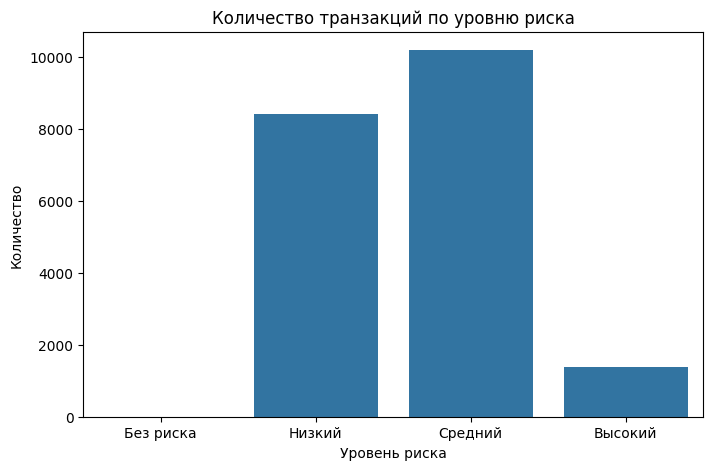

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='risk', order=['Без риска','Низкий','Средний','Высокий'])
plt.title("Количество транзакций по уровню риска")
plt.ylabel("Количество")
plt.xlabel("Уровень риска")
plt.show()

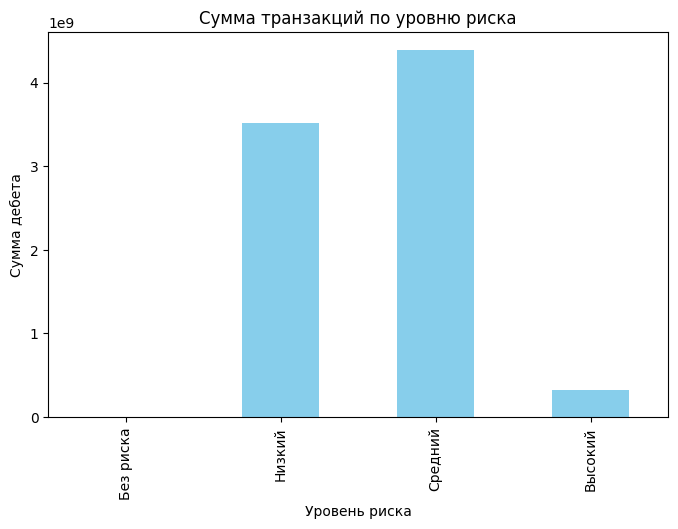

In [12]:
df_grouped = df.groupby('risk')['debit_amount'].sum().reindex(['Без риска','Низкий','Средний','Высокий'])
df_grouped.plot(kind='bar', figsize=(8,5), color='skyblue')
plt.title("Сумма транзакций по уровню риска")
plt.ylabel("Сумма дебета")
plt.xlabel("Уровень риска")
plt.show()

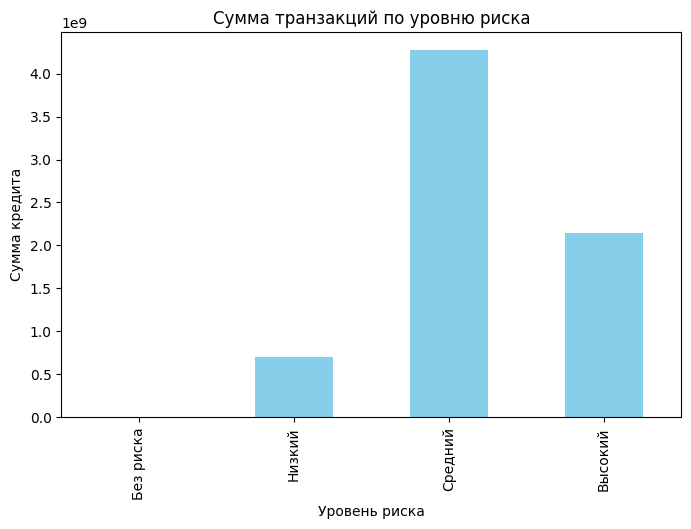

In [13]:
df_grouped = df.groupby('risk')['credit_amount'].sum().reindex(['Без риска','Низкий','Средний','Высокий'])
df_grouped.plot(kind='bar', figsize=(8,5), color='skyblue')
plt.title("Сумма транзакций по уровню риска")
plt.ylabel("Сумма кредита")
plt.xlabel("Уровень риска")
plt.show()

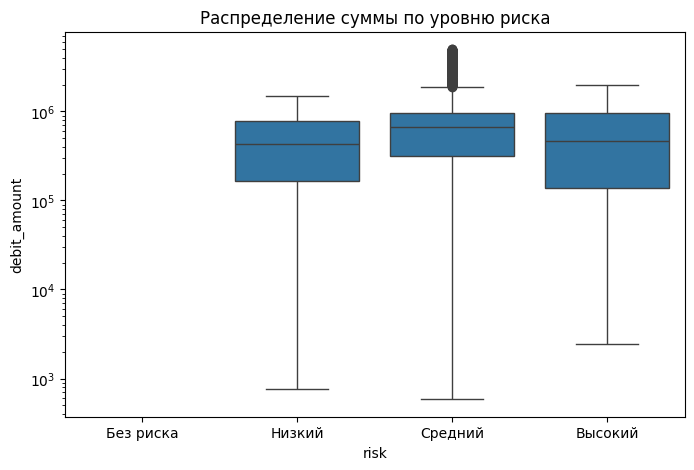

In [14]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='risk', y='debit_amount', order=['Без риска','Низкий','Средний','Высокий'])
plt.yscale('log')  # если есть большие суммы
plt.title("Распределение суммы по уровню риска")
plt.show()


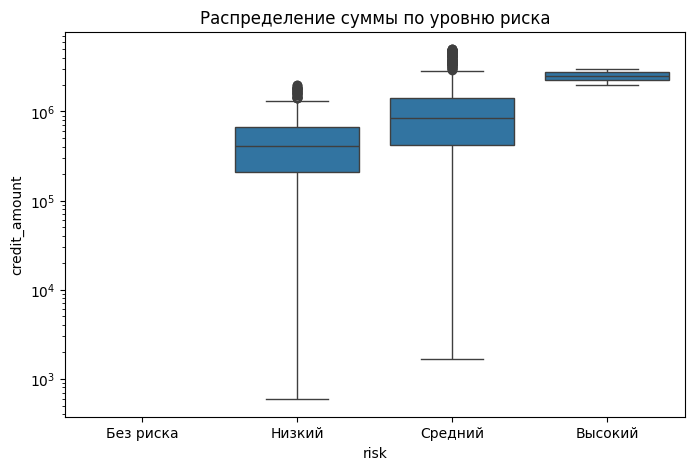

In [15]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='risk', y='credit_amount', order=['Без риска','Низкий','Средний','Высокий'])
plt.yscale('log')  # если есть большие суммы
plt.title("Распределение суммы по уровню риска")
plt.show()


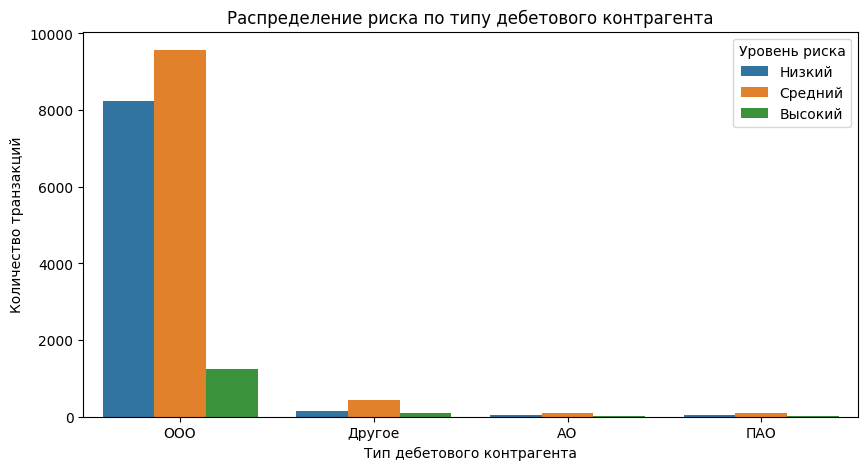

In [16]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='debit_name_type', hue='risk')
plt.title("Распределение риска по типу дебетового контрагента")
plt.ylabel("Количество транзакций")
plt.xlabel("Тип дебетового контрагента")
plt.legend(title="Уровень риска")
plt.show()

#### Напоминание!!!
* 0 - Высокий риск
* 1 - Средний риск
* 2 - Низкий риск

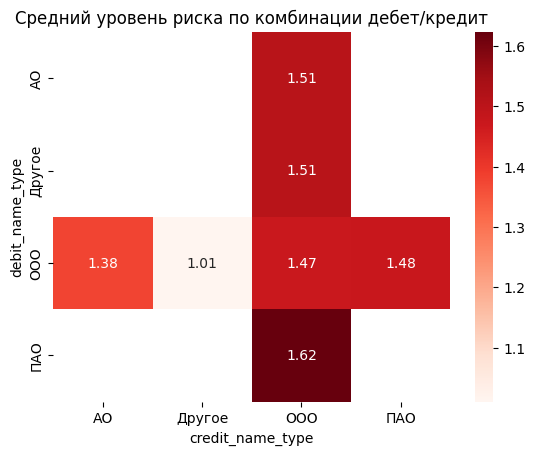

In [17]:
pivot = df.pivot_table(index='debit_name_type', columns='credit_name_type', values='risk_encoded', aggfunc='mean')
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="Reds")
plt.title("Средний уровень риска по комбинации дебет/кредит")
plt.show()

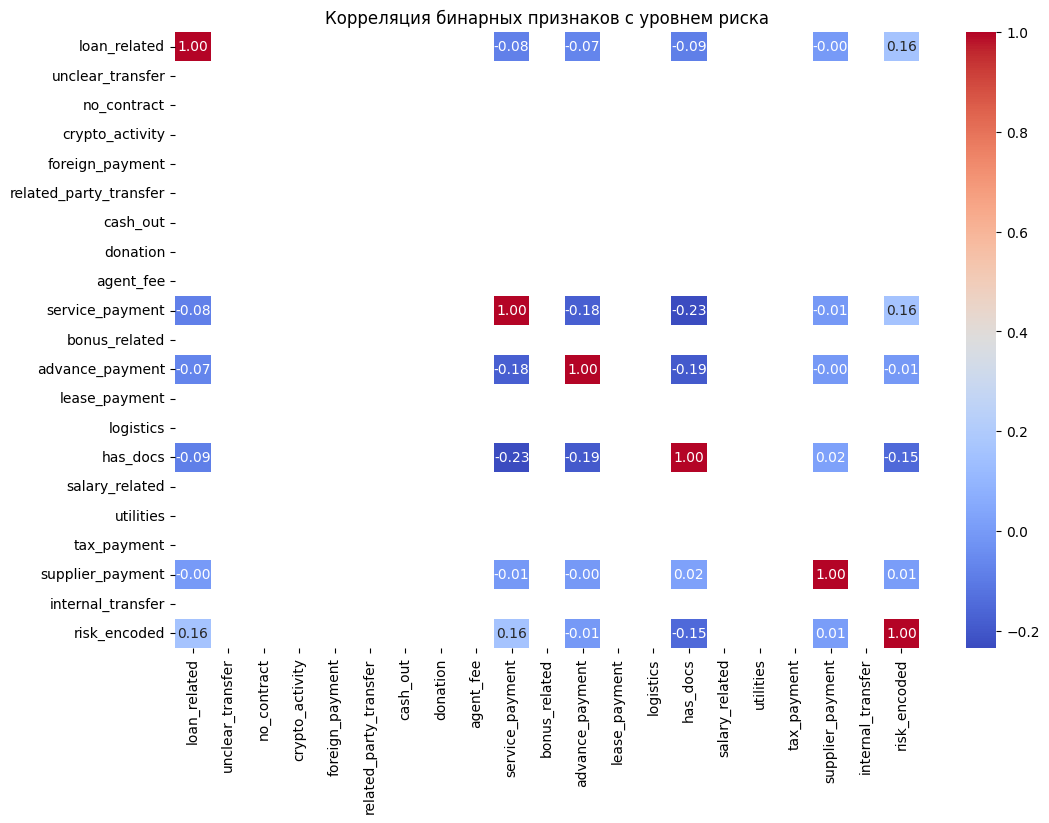

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Список бинарных признаков
binary_cols = [
    'loan_related','unclear_transfer','no_contract','crypto_activity',
    'foreign_payment','related_party_transfer','cash_out','donation','agent_fee',
    'service_payment','bonus_related','advance_payment','lease_payment','logistics',
    'has_docs','salary_related','utilities','tax_payment','supplier_payment','internal_transfer'
]

# Корреляция бинарных признаков с risk_encoded
corr_matrix = df_final[binary_cols + ['risk_encoded']].corr()

# Строим тепловую карту
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляция бинарных признаков с уровнем риска")
plt.show()


## Вывод

## Пробуем применить модели машинного обучения

### Что мы имеем сейчас? 
* На данный момент мы подготовили данные для обучения модели:
  - Созданы бинарные признаки по ключевым словам из назначения платежа (`purpose`)
  - Колонка `risk` закодирована в `risk_encoded` с числами от 0 до 3
  - Текстовые признаки `debit_name_type` и `credit_name_type` представлены через OneHotEncoding
  - Проведён предварительный анализ распределения риска, суммы транзакций и контрагентов

* Проанализировали данные:
  - Построены графики распределения риска, суммы транзакций и бинарных признаков
  - Выявлены ключевые признаки, которые коррелируют с уровнем риска
  - Проведён анализ выбросов и распределения категориальных признаков

---

Теперь мы готовы переходить к **обучению моделей машинного обучения**, чтобы попытаться **классифицировать транзакции по уровню риска** на основе подготовленных признаков.


In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score
from imblearn.over_sampling import SMOTE
import joblib

# ======== 2. Выбираем бинарные признаки как X ========
features = [
    'loan_related', 'unclear_transfer', 'no_contract', 'crypto_activity',
    'foreign_payment','related_party_transfer','cash_out','donation','agent_fee',
    'service_payment','bonus_related','advance_payment','lease_payment','logistics',
    'has_docs','salary_related','utilities','tax_payment','supplier_payment','internal_transfer',
    'debit_name_type_АО','debit_name_type_Другое','debit_name_type_ООО','debit_name_type_ПАО',
    'credit_name_type_АО','credit_name_type_Другое','credit_name_type_ООО','credit_name_type_ПАО'
]
X = df_final[features]
y = df_final['risk_encoded']

# ======== 3. Разделение на train/test ========
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ======== 3.1 Балансировка классов с помощью SMOTE ========
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("До SMOTE:", y_train.value_counts())
print("После SMOTE:", pd.Series(y_train_res).value_counts())

# ======== 4. Классификация ========

# --- 4.1 Random Forest Classifier ---
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_res, y_train_res)
y_pred_rf = rf_clf.predict(X_test)
print("=== Random Forest Classifier ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# --- 4.2 Логистическая регрессия (мультикласс) ---
logreg = LogisticRegression(max_iter=1000, multi_class='multinomial')
logreg.fit(X_train_res, y_train_res)
y_pred_lr = logreg.predict(X_test)
print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# ======== 5. Линейная регрессия (аппроксимация risk_encoded) ========
linreg = LinearRegression()
linreg.fit(X_train_res, y_train_res)
y_pred_lin = linreg.predict(X_test)

# Округление до целых чисел 0-3
y_pred_lin_rounded = y_pred_lin.round().clip(0,3).astype(int)
print("=== Linear Regression (rounded) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lin_rounded))
print("MSE:", mean_squared_error(y_test, y_pred_lin_rounded))
print(classification_report(y_test, y_pred_lin_rounded))

# ======== 6. Random Forest Regressor ========
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_res, y_train_res)
y_pred_rf_reg = rf_reg.predict(X_test)

joblib.dump(rf_reg, "rf_reg_model.pkl")

# Округление до целых чисел 0-3
y_pred_rf_reg_rounded = y_pred_rf_reg.round().clip(0,3).astype(int)
print("=== Random Forest Regressor (rounded) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_reg_rounded))
print("MSE:", mean_squared_error(y_test, y_pred_rf_reg_rounded))
print(classification_report(y_test, y_pred_rf_reg_rounded))


До SMOTE: risk_encoded
2    8158
1    6746
0    1096
Name: count, dtype: int64
После SMOTE: risk_encoded
1    8158
2    8158
0    8158
Name: count, dtype: int64
=== Random Forest Classifier ===
Accuracy: 0.505
              precision    recall  f1-score   support

           0       0.28      1.00      0.44       274
           1       0.53      0.68      0.60      1686
           2       0.68      0.29      0.41      2040

    accuracy                           0.51      4000
   macro avg       0.50      0.66      0.48      4000
weighted avg       0.59      0.51      0.49      4000

=== Logistic Regression ===
Accuracy: 0.4925
              precision    recall  f1-score   support

           0       0.27      1.00      0.43       274
           1       0.52      0.66      0.58      1686
           2       0.67      0.29      0.40      2040

    accuracy                           0.49      4000
   macro avg       0.49      0.65      0.47      4000
weighted avg       0.58      0.49     

/Users/stanislav/Documents/Work/bank_agent/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Random Forest Regressor (rounded) ===
Accuracy: 0.52325
MSE: 0.57425
              precision    recall  f1-score   support

           0       0.44      0.48      0.46       274
           1       0.48      0.81      0.61      1686
           2       0.68      0.29      0.41      2040

    accuracy                           0.52      4000
   macro avg       0.53      0.53      0.49      4000
weighted avg       0.58      0.52      0.50      4000



/Users/stanislav/Documents/Work/bank_agent/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:24:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost ===
Accuracy: 0.50475
              precision    recall  f1-score   support

           0       0.28      1.00      0.44       274
           1       0.53      0.68      0.60      1686
           2       0.68      0.29      0.41      2040

    accuracy                           0.50      4000
   macro avg       0.50      0.66      0.48      4000
weighted avg       0.59      0.50      0.49      4000



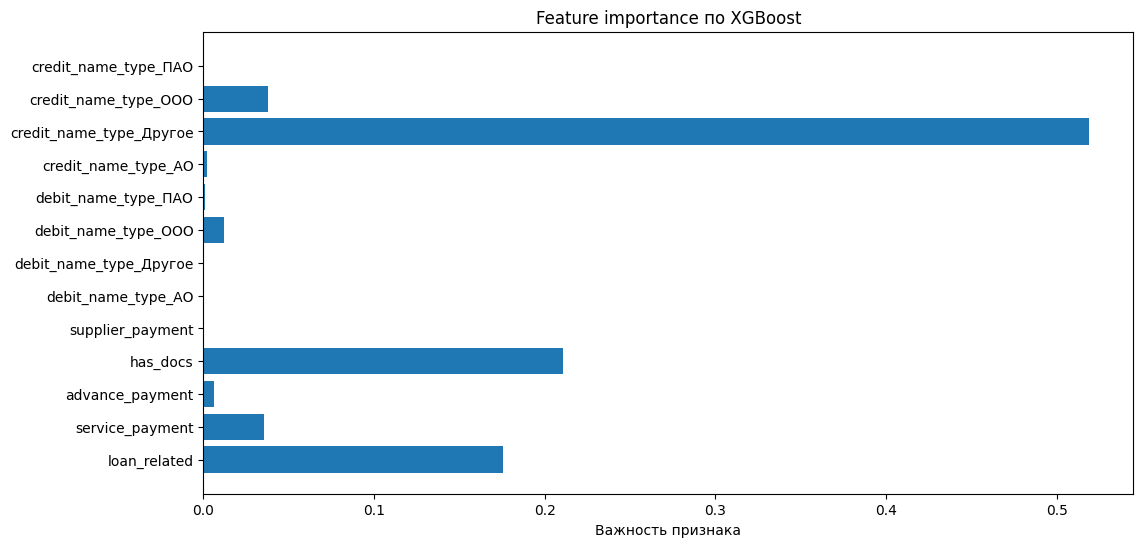

In [94]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
# ======== 4. Обучение XGBoost ========
xgb_clf = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

xgb_clf.fit(X_train_res, y_train_res)
y_pred = xgb_clf.predict(X_test)

# ======== 5. Метрики ========
print("=== XGBoost ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ======== 6. Важность признаков ========
importances = xgb_clf.feature_importances_
plt.figure(figsize=(12,6))
plt.barh(features, importances)
plt.title("Feature importance по XGBoost")
plt.xlabel("Важность признака")
plt.show()

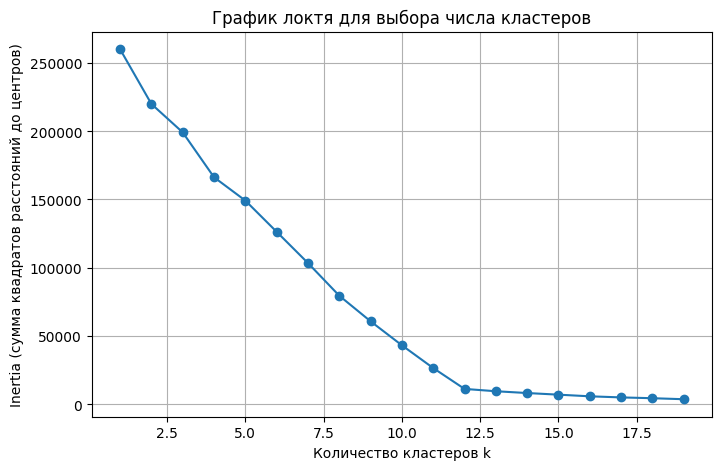

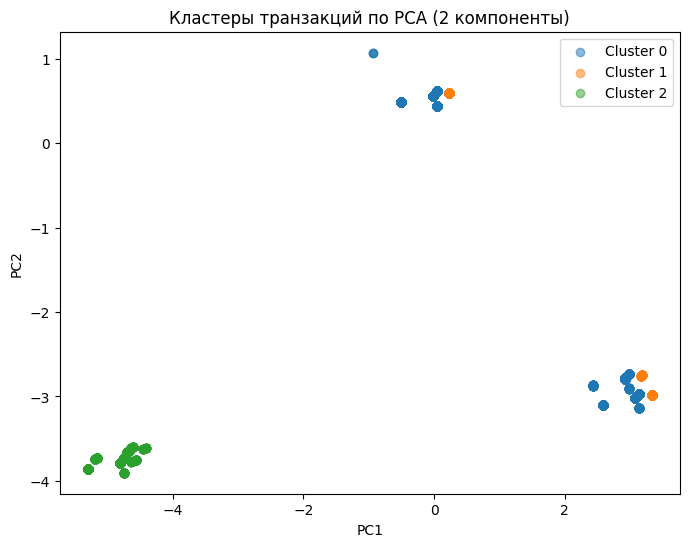

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# ======== 1. Выбираем бинарные признаки ========
features = [
    'loan_related', 'unclear_transfer', 'no_contract', 'crypto_activity',
    'foreign_payment','related_party_transfer','cash_out','donation','agent_fee',
    'service_payment','bonus_related','advance_payment','lease_payment','logistics',
    'has_docs','salary_related','utilities','tax_payment','supplier_payment','internal_transfer',
    'debit_name_type_АО','debit_name_type_Другое','debit_name_type_ООО','debit_name_type_ПАО',
    'credit_name_type_АО','credit_name_type_Другое','credit_name_type_ООО','credit_name_type_ПАО'
]

X = df_final[features]

# ======== 2. Стандартизация (необязательна для бинарных признаков, но полезна для KMeans) ========
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ======== 3. График локтя ========
inertia = []
K_range = range(1, 20)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o')
plt.title('График локтя для выбора числа кластеров')
plt.xlabel('Количество кластеров k')
plt.ylabel('Inertia (сумма квадратов расстояний до центров)')
plt.grid(True)
plt.show()

# ======== 4. Применение KMeans с выбранным числом кластеров ========
optimal_k = 3  # например, по графику локтя
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Добавим колонку с кластером в DataFrame
df_final['cluster'] = clusters

# ======== 5. Визуализация кластеров через PCA ========
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
for cluster in range(optimal_k):
    plt.scatter(
        X_pca[clusters==cluster, 0],
        X_pca[clusters==cluster, 1],
        label=f'Cluster {cluster}',
        alpha=0.5
    )
plt.title('Кластеры транзакций по PCA (2 компоненты)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


## Вывод по результатам классификации на синтетических данных

### Общая оценка модели

- Accuracy моделей: ~50%  
- Precision и Recall сильно различаются по классам:
  
| Класс | Precision | Recall | F1-score | Комментарий |
|-------|-----------|--------|----------|-------------|
| 0 (высокий риск) | 0.28–0.40 | 0.48–1.00 | 0.43–0.44 | Редкий класс: модель почти все распознаёт (high recall), но много ложноположительных. |
| 1 (средний риск) | 0.47–0.53 | 0.66–0.81 | 0.58–0.60 | Средний риск: модель лучше балансирует точность и полноту. |
| 2 (низкий риск) | 0.67–0.68 | 0.25–0.29 | 0.37–0.41 | Низкий риск: высокая точность, но модель пропускает большинство транзакций этого класса (низкий recall). |

---

### Почему гипотеза провалилась / результаты ограничены

1. **Синтетические данные**  
   - Генератор транзакций не полностью моделирует реальные экономические зависимости.  
   - Признаки бинарные и искусственные, нет сложных корреляций между ними и `risk_encoded`.  

2. **Несбалансированные классы**  
   - До SMOTE класс низкого риска был недопредставлен, после SMOTE баланс улучшился, но модели всё равно плохо распознают большинство транзакций низкого риска на тесте.  

3. **Ограниченность признаков**  
   - Признаки созданы по ключевым словам и типу контрагента, но для надёжного различения всех классов их недостаточно.  

---

### Практическая интерпретация

- Для синтетики текущие результаты **достаточны для тестирования моделей и LLM** на пояснениях.  
- **Для реальных данных**:
  - Необходимо:
    1. Использовать более информативные признаки.   
    2. Проводить балансировку и настройку порогов для редких классов.  

---

### Вывод

> На синтетических данных гипотеза о том, что базовые бинарные признаки позволяют надежно классифицировать все три уровня риска, **не подтвердилась**.  
>  
> Эти эксперименты показывают потенциал подхода, но для практического использования **необходимо проверять на реальных данных**, где признаки будут более информативными и корреляции с риском — естественными.


In [157]:
import numpy as np

# ======== Выбираем случайную строку ========
random_idx = np.random.randint(0, len(df_final))
sample_row = df_final.iloc[random_idx]

# Отбираем только бинарные признаки
sample_features = sample_row[features].values.reshape(1, -1)

# ======== Предсказание RandomForestRegressor ========
predicted_value = rf_reg.predict(sample_features)
predicted_class = int(np.round(predicted_value).clip(0,3))  # округление и защита

print("Случайная транзакция (индекс {}):".format(random_idx))
print(sample_row[features])
print("Предсказанное значение RF Regressor:", predicted_value[0])
print("Округлённый предсказанный класс:", predicted_class)
print("Истинный класс:", sample_row['risk_encoded'])


Случайная транзакция (индекс 4024):
loan_related               0
service_payment            0
advance_payment            0
has_docs                   0
supplier_payment           0
debit_name_type_АО         0
debit_name_type_Другое     0
debit_name_type_ООО        1
debit_name_type_ПАО        0
credit_name_type_АО        0
credit_name_type_Другое    0
credit_name_type_ООО       1
credit_name_type_ПАО       0
Name: 4024, dtype: object
Предсказанное значение RF Regressor: 1.417357458924351
Округлённый предсказанный класс: 1
Истинный класс: 1


/Users/stanislav/Documents/Work/bank_agent/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/var/folders/hx/6vltr8z949358k44l1m6_b7m0000gn/T/ipykernel_2379/2825134703.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = int(np.round(predicted_value).clip(0,3))  # округление и защита
